In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.shape

(891, 12)

In [5]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
test_data.shape

(418, 11)

# Exploring the training data

In [7]:
# Removing columns "Name", "Ticket" and "Passenger ID" as they don't have a meaning

eda_data = train_data.drop(columns = (['Name', 'PassengerId', 'Ticket']))

<Axes: >

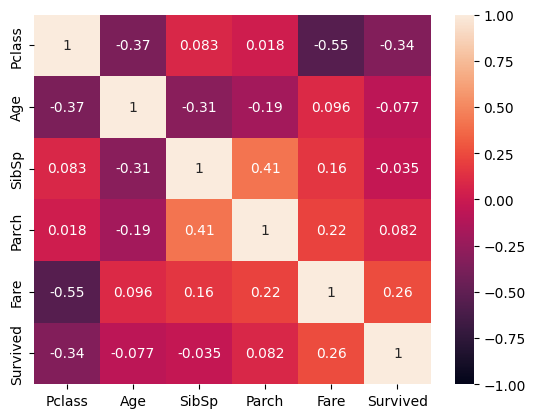

In [8]:
# Correlation matrix of the numeric features to check if there is a noticiable correlation between the target feature and any of the others
sns.heatmap(eda_data[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']].corr(), vmin = -1, vmax = 1, annot = True)

<Axes: xlabel='Sex', ylabel='count'>

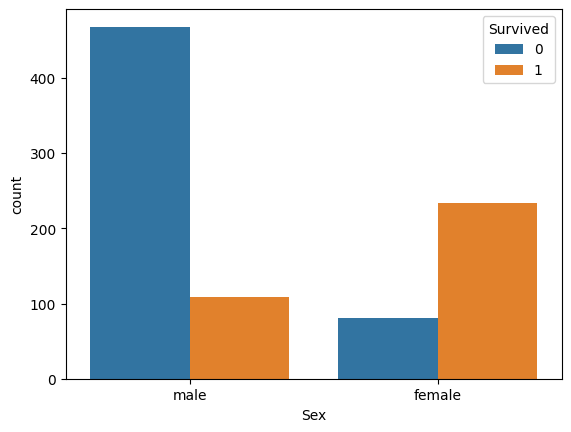

In [9]:
# Do a countplot to check if there is any relation between the target variable and the Sex
sns.countplot(x='Sex', hue='Survived', data = eda_data)
#Below we can see a trend where most male died while most female lived

<Axes: xlabel='Embarked', ylabel='count'>

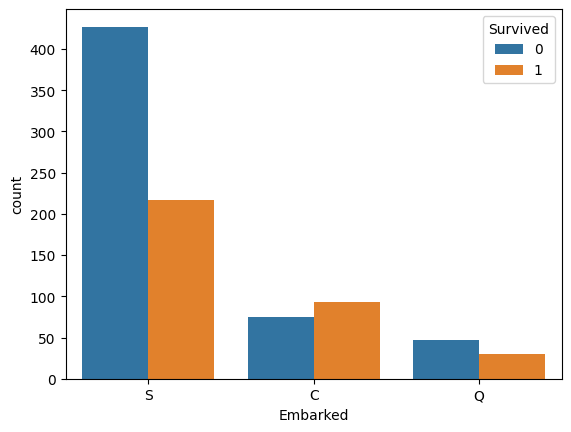

In [10]:
# Do a countplot to check if there is any relation between the target variable and the Port they embarked
sns.countplot(x='Embarked', hue='Survived', data = eda_data)
# At first seight it seems that people who embarked on Cherbourg had a bigger chance of living
# Altought it may not make sense at first, we will keep this feature to check if ot impacts the models predictions

In [11]:
eda_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [12]:
# Check if there are null values on the data
for column in eda_data.columns:
    nan_count = eda_data[column].isna().sum()
    print(f'the column {column} has {nan_count} missing data points')

the column Survived has 0 missing data points
the column Pclass has 0 missing data points
the column Sex has 0 missing data points
the column Age has 177 missing data points
the column SibSp has 0 missing data points
the column Parch has 0 missing data points
the column Fare has 0 missing data points
the column Cabin has 687 missing data points
the column Embarked has 2 missing data points


The column "Cabin" has too many missing values, so I'll remove it from the dataset

The column "Embarked" has only two missing values so I'll attribute them the most common embark port

The column "Age" has 177 missing values, but they can't be ignored, so I'll impute the average age according to their sex

In [13]:
# Droping the "Cabin" column
eda_data.drop(columns=['Cabin'], inplace = True)


In [14]:
#As we saw, most passengers embarked from "Southampton", so I'll impute it to those 2 passagenrs
eda_data['Embarked'] = eda_data['Embarked'].fillna('S')

In [15]:
# Filling the 'Age' NaN with the average age of each 'Sex'

eda_data['Age'] = eda_data['Age'].fillna(eda_data.groupby('Sex')['Age'].transform('mean'))

# Preprocess the data to feed the model

In [16]:
from sklearn.model_selection import train_test_split #It won't be necessary
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [17]:
X_train = eda_data.drop(columns = 'Survived')
y_train = eda_data['Survived']

In [18]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [19]:
# Define the columns to encode

categorical_columns = ['Sex', 'Embarked']
ordinal_columns = ['Pclass']
numerical_columns = ['Age', 'SibSp', 'Parch', 'Fare']



In [20]:
# Instantiate the transformer to apply to each column type

categorical_transformer = OneHotEncoder()
ordinal_transformer = OrdinalEncoder()
numerical_transformer = StandardScaler()

In [21]:
# Create the processor to make the tranformations

preprocessor = ColumnTransformer(
    [
        ("cat", categorical_transformer, categorical_columns),
        ("ord", ordinal_transformer, ordinal_columns),
        ("num", numerical_transformer, numerical_columns)
    ]
)

In [22]:
# Transform the data and fit the preprocessor

X_train_transformed = preprocessor.fit_transform(X_train)

# Neural Network model

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [24]:
X_train_transformed.shape

(891, 10)

In [25]:
# Reshape the X_train_transformed to feed the model
X_train_transformed = X_train_transformed.reshape((X_train_transformed.shape[0], 1, X_train_transformed.shape[1]))

In [26]:
model = Sequential(
    [
        tf.keras.Input(shape=(891,10)),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ]    
)

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 891, 64)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 891, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 891, 1)         │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    tf.keras.optimizers.Adam(0.01),
    tf.keras.losses.BinaryCrossentropy
)

In [29]:
model.fit(X_train_transformed, y_train, epochs = 10)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5764
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4397 
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4345 
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4271
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4156
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3742 
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3571 
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3642 
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4230 
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3759 


In [30]:
def make_prediction(X_pred, output='predictions.csv'):

    passenger_ids = X_pred['PassengerId'].values
    
    X_pred = X_pred.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin'])
    X_pred_transformed = preprocessor.transform(X_pred)
    X_pred_transformed = X_pred_transformed.reshape((X_pred_transformed.shape[0], 1, X_pred_transformed.shape[1]))

    predictions = model.predict(X_pred_transformed)
    binary_predictions = (predictions >= 0.5).astype(int).flatten()

    predictions_df = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Survived': binary_predictions
    })

    predictions_df.to_csv(output, index=False)
    
    return predictions_df

    

In [31]:
print(make_prediction(test_data))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]
